In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
ticker = "TSLA"
start_date = "2021-07-27"  # 3 years ago from today
end_date = "2024-07-27"  # Today's date
tesla_data = yf.download(ticker, start=start_date, end=end_date)
tesla_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-27,221.133331,222.166672,209.080002,214.926666,214.926666,98439900
2021-07-28,215.666672,218.323334,213.133331,215.660004,215.660004,48019800
2021-07-29,216.596664,227.896667,216.266663,225.783340,225.783340,91183800
2021-07-30,223.919998,232.509995,223.000000,229.066666,229.066666,88969200
2021-08-02,233.333328,242.313339,232.800003,236.556671,236.556671,100847400


In [4]:
tesla_data.to_csv("tesla_stock_data.csv")

In [5]:
missing_values = tesla_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
tesla_data['SMA_7'] = tesla_data['Close'].rolling(window=7).mean()
tesla_data['SMA_30'] = tesla_data['Close'].rolling(window=30).mean()
tesla_data['EMA_12'] = tesla_data['Close'].ewm(span=12, adjust=False).mean()
tesla_data['EMA_26'] = tesla_data['Close'].ewm(span=26, adjust=False).mean()

In [8]:
tesla_data['MACD'] = tesla_data['EMA_12'] - tesla_data['EMA_26']
tesla_data['Signal_Line'] = tesla_data['MACD'].ewm(span=9, adjust=False).mean()

In [9]:
delta = tesla_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
tesla_data['RSI'] = 100 - (100 / (1 + rs))

In [10]:
tesla_data['BB_upper'] = tesla_data['SMA_30'] + (tesla_data['Close'].rolling(window=30).std() * 2)
tesla_data['BB_lower'] = tesla_data['SMA_30'] - (tesla_data['Close'].rolling(window=30).std() * 2)

In [11]:
high_low = tesla_data['High'] - tesla_data['Low']
high_close = np.abs(tesla_data['High'] - tesla_data['Close'].shift())
low_close = np.abs(tesla_data['Low'] - tesla_data['Close'].shift())
tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
tesla_data['ATR'] = tr.rolling(window=14).mean()

In [12]:
tesla_data['OBV'] = (np.sign(tesla_data['Close'].diff()) * tesla_data['Volume']).fillna(0).cumsum()

In [13]:
tesla_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_30,EMA_12,EMA_26,MACD,Signal_Line,RSI,BB_upper,BB_lower,ATR,OBV
Date,,,,,,,,,,,,,,,,,
2021-07-27,221.133331,222.166672,209.080002,214.926666,214.926666,98439900,NaN,NaN,214.926666,214.926666,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0
2021-07-28,215.666672,218.323334,213.133331,215.660004,215.660004,48019800,NaN,NaN,215.039487,214.980988,0.058500,0.011700,NaN,NaN,NaN,NaN,48019800.0
2021-07-29,216.596664,227.896667,216.266663,225.783340,225.783340,91183800,NaN,NaN,216.692388,215.781162,0.911226,0.191605,NaN,NaN,NaN,NaN,139203600.0
2021-07-30,223.919998,232.509995,223.000000,229.066666,229.066666,88969200,NaN,NaN,218.596123,216.765273,1.830850,0.519454,NaN,NaN,NaN,NaN,228172800.0
2021-08-02,233.333328,242.313339,232.800003,236.556671,236.556671,100847400,NaN,NaN,221.359284,218.231303,3.127981,1.041160,NaN,NaN,NaN,NaN,329020200.0


In [14]:
nan_rows = tesla_data[tesla_data.isna().any(axis=1)]
print(nan_rows)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-07-27  221.133331  222.166672  209.080002  214.926666  214.926666   
2021-07-28  215.666672  218.323334  213.133331  215.660004  215.660004   
2021-07-29  216.596664  227.896667  216.266663  225.783340  225.783340   
2021-07-30  223.919998  232.509995  223.000000  229.066666  229.066666   
2021-08-02  233.333328  242.313339  232.800003  236.556671  236.556671   
2021-08-03  239.666672  240.883331  233.669998  236.580002  236.580002   
2021-08-04  237.000000  241.633331  236.309998  236.973328  236.973328   
2021-08-05  238.666672  240.316666  237.136673  238.210007  238.210007   
2021-08-06  237.300003  238.776672  232.543335  233.033340  233.033340   
2021-08-09  236.723328  239.676666  235.043335  237.919998  237.919998   
2021-08-10  237.996674  238.863327  233.960007  236.663330  236.663330   
2021-08-11  237.570007  238.393326  23

In [15]:
tesla_data = tesla_data.iloc[30:].copy()

In [16]:
print(tesla_data.isna().sum())

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
SMA_7          0
SMA_30         0
EMA_12         0
EMA_26         0
MACD           0
Signal_Line    0
RSI            0
BB_upper       0
BB_lower       0
ATR            0
OBV            0
dtype: int64


In [17]:
tesla_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_30,EMA_12,EMA_26,MACD,Signal_Line,RSI,BB_upper,BB_lower,ATR,OBV
Date,,,,,,,,,,,,,,,,,
2021-09-08,253.860001,254.816666,246.923340,251.289993,251.289993,56379000,246.355715,235.930223,242.872851,237.025025,5.847827,4.712840,76.447101,252.337051,219.523395,5.794999,679356000.0
2021-09-09,251.136673,254.033340,250.543335,251.619995,251.619995,42233100,247.496190,237.128889,244.218566,238.106133,6.112432,4.992759,87.635254,252.637584,221.620195,5.534762,721589100.0
2021-09-10,253.199997,254.203339,244.839996,245.423340,245.423340,45552600,247.522380,237.783556,244.403915,238.648149,5.755767,5.145360,73.351146,252.965150,222.601962,5.759286,676036500.0
2021-09-13,246.736664,248.259995,236.283340,247.666672,247.666672,68857500,247.946666,238.403556,244.905878,239.316188,5.589690,5.234226,68.236949,253.631234,223.175879,5.855952,744894000.0
2021-09-14,247.523331,251.490005,245.466660,248.163330,248.163330,55574700,248.522855,238.790445,245.407024,239.971531,5.435493,5.274480,68.014426,254.408725,223.172165,5.986667,800468700.0


In [18]:
correlation_matrix = tesla_data.corr()
correlation_with_close = correlation_matrix['Close'].sort_values(ascending=False)
print(correlation_with_close)

Close          1.000000
Adj Close      1.000000
Low            0.996900
High           0.996063
Open           0.991438
SMA_7          0.977600
EMA_12         0.967628
EMA_26         0.922144
SMA_30         0.869593
BB_upper       0.863889
BB_lower       0.778536
ATR            0.661164
Signal_Line    0.506562
MACD           0.485118
RSI            0.304390
OBV           -0.256929
Volume        -0.402528
Name: Close, dtype: float64


In [19]:
features = ['SMA_7', 'SMA_30', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'RSI', 'BB_upper', 'BB_lower', 'ATR', 'OBV']
target = 'Close'

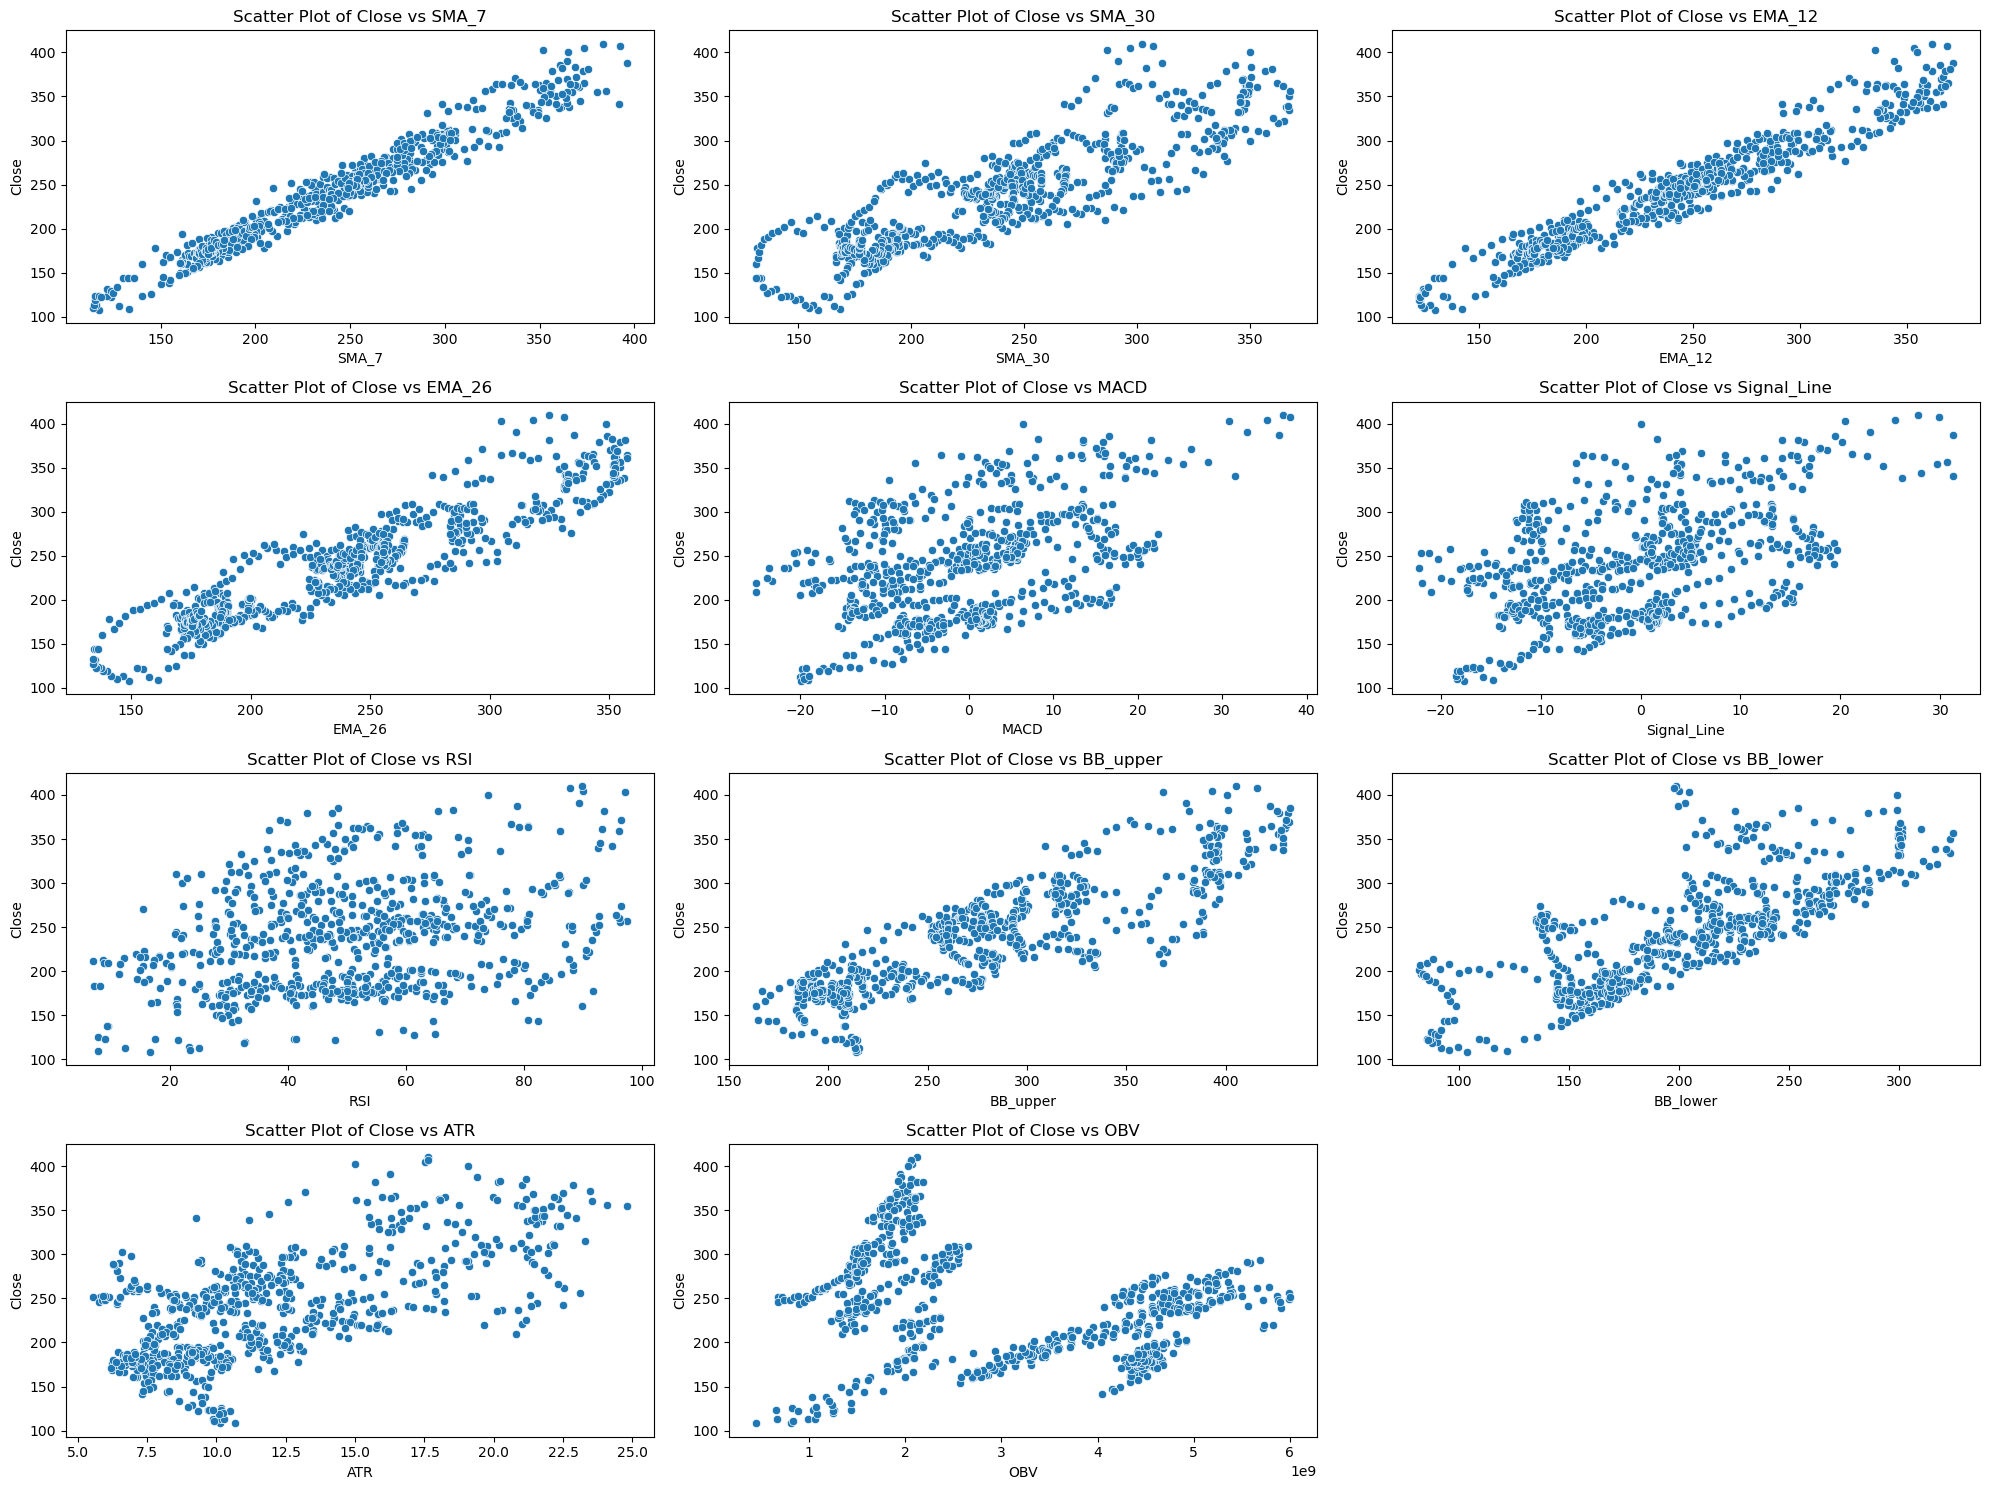

In [20]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=tesla_data[feature], y=tesla_data['Close'])
    plt.title(f'Scatter Plot of Close vs {feature}')
plt.tight_layout()
plt.show()

In [21]:
X = tesla_data[features]
y = tesla_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print("Training set shape (X_train):", X_train.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (580, 11)
Training set shape (y_train): (580,)
Testing set shape (X_test): (145, 11)
Testing set shape (y_test): (145,)


In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [24]:
model.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = model.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [27]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 26.658901791164613
Root Mean Squared Error (RMSE): 5.163225909367574
Mean Absolute Error (MAE): 3.7709184648018845
R-squared (R²): 0.9943177303461158
